In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time, os
from pathlib import Path
import random
import cv2

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB3

In [15]:
path = "6 Emotions for image classification"
classes = sorted(os.listdir(path))
classes

['anger', 'disgust', 'fear', 'happy', 'pain', 'sad']

In [17]:
anger_path = "6 Emotions for image classification/anger"
disgust_path = "6 Emotions for image classification/disgust"
fear_path = "6 Emotions for image classification/fear"
happy_path = "6 Emotions for image classification/happy"
pain_path = "6 Emotions for image classification/pain"
sad_path = "6 Emotions for image classification/sad"

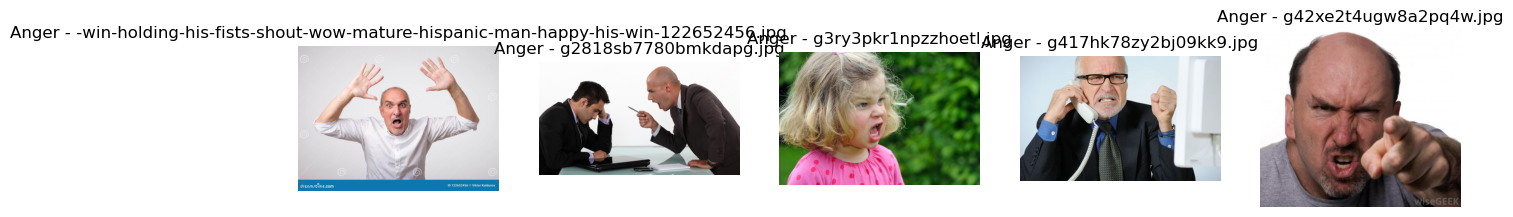

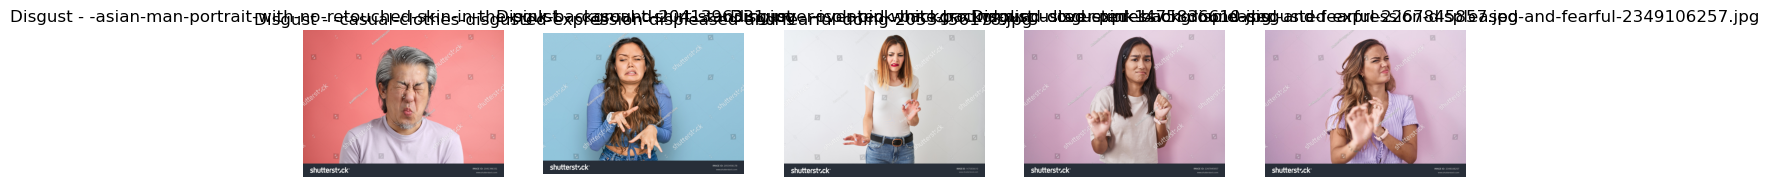

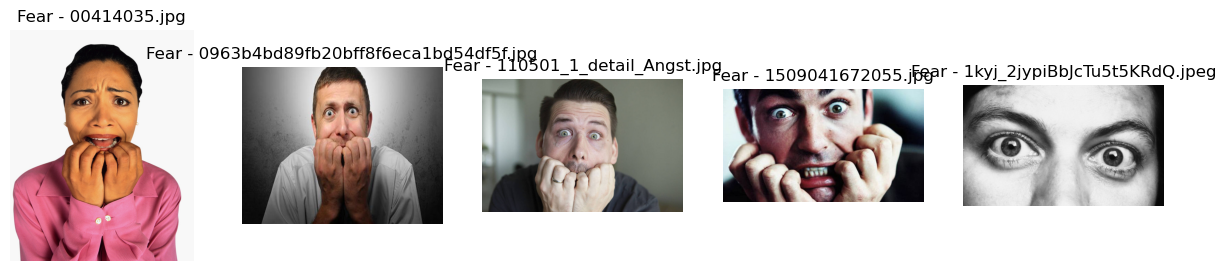

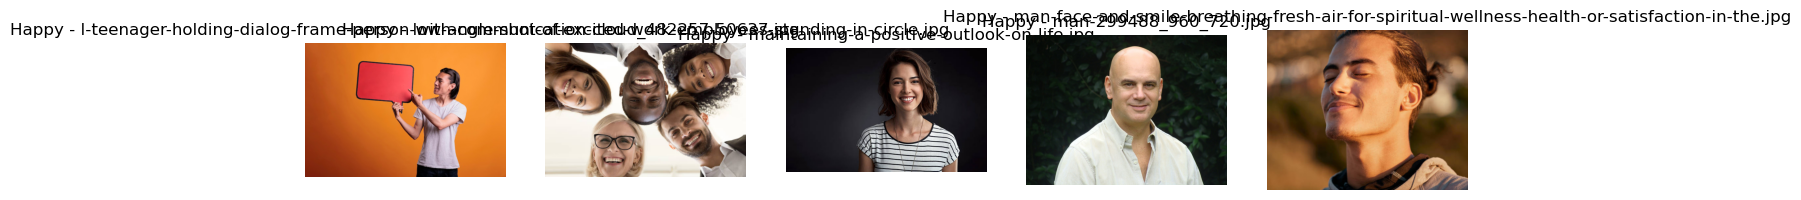

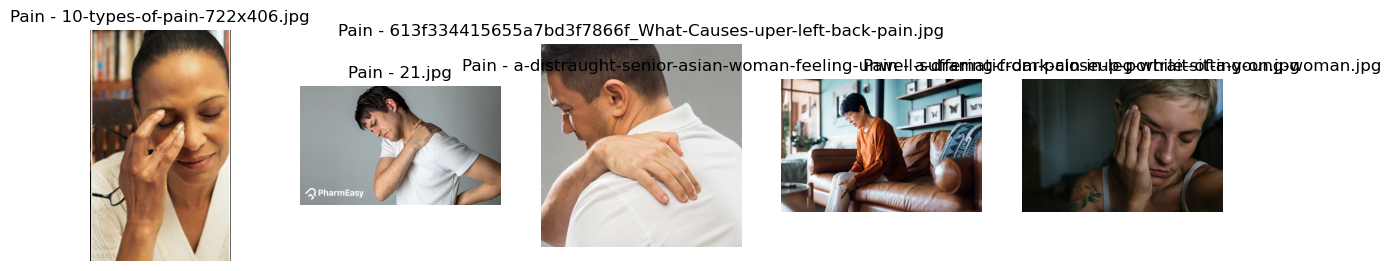

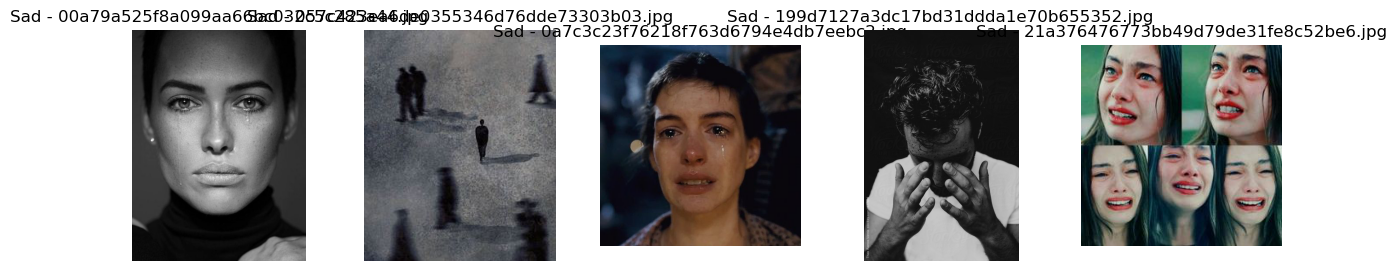

In [21]:
def load_sample_images(folder_path, num_samples=5):
    sample_images = []
    for root, dirs, files in os.walk(folder_path):
        for i, file in enumerate(files):
            if i >= num_samples:
                break
            image_path = os.path.join(root, file)
            image = Image.open(image_path)
            image = image.convert('RGB')
            sample_images.append((file, image))
    return sample_images

def display_sample_images(sample_images, label):
    plt.figure(figsize=(15, 3))
    for i, (file, image) in enumerate(sample_images):
        plt.subplot(1, len(sample_images), i + 1)
        plt.imshow(image)
        plt.title(f"{label} - {file}")
        plt.axis("off")
    plt.show()

anger_samples = load_sample_images(anger_path)
display_sample_images(anger_samples, 'Anger')


disgust_samples = load_sample_images(disgust_path)
display_sample_images(disgust_samples, 'Disgust')


fear_samples = load_sample_images(fear_path)
display_sample_images(fear_samples, 'Fear')

happy_samples = load_sample_images(happy_path)
display_sample_images(happy_samples, 'Happy')

pain_samples = load_sample_images(pain_path)
display_sample_images(pain_samples, 'Pain')

sad_samples = load_sample_images(sad_path)
display_sample_images(sad_samples, 'Sad')

In [23]:
def dataset_statistics(folder_path):
    class_counts = {}
    for root, dirs, files in os.walk(folder_path):
        if files:
            class_name = os.path.basename(root)
            class_counts[class_name] = len(files)
    return class_counts

input_folder = [anger_path, fear_path, disgust_path, happy_path, pain_path, sad_path]
print("Dataset Statistics:")
for input in input_folder:
  dataset_stats = dataset_statistics(input)
  for class_name, count in dataset_stats.items():
      print(f"{class_name}: {count} images")

Dataset Statistics:
anger: 214 images
fear: 163 images
disgust: 195 images
happy: 230 images
pain: 168 images
sad: 224 images


In [25]:
for filename in os.listdir(path):
    if (filename.endswith(ext) for ext in ['.jpeg', '.png', '.gif']):
        prefix = os.path.splitext(filename)[0]
        os.rename(os.path.join(path, filename), os.path.join(path, prefix+'.jpg'))
    else:
        continue

In [27]:
def to_frame(path):
    class_types = []
    class_paths = []
    files = os.listdir(path)
    for file in files:
        label_dir = os.path.join(path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            class_name = os.path.splitext(file)[0]
            class_types.append(class_name)
    image_classes = pd.Series(class_types, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    df = pd.concat([image_paths, image_classes], axis=1)
    return df

In [29]:
df = to_frame(path)

In [31]:
df.head()

,Class Path,Class
0,6 Emotions for image classification\anger.jpg\...,anger
1,6 Emotions for image classification\anger.jpg\...,anger
2,6 Emotions for image classification\anger.jpg\...,anger
3,6 Emotions for image classification\anger.jpg\...,anger
4,6 Emotions for image classification\anger.jpg\...,anger


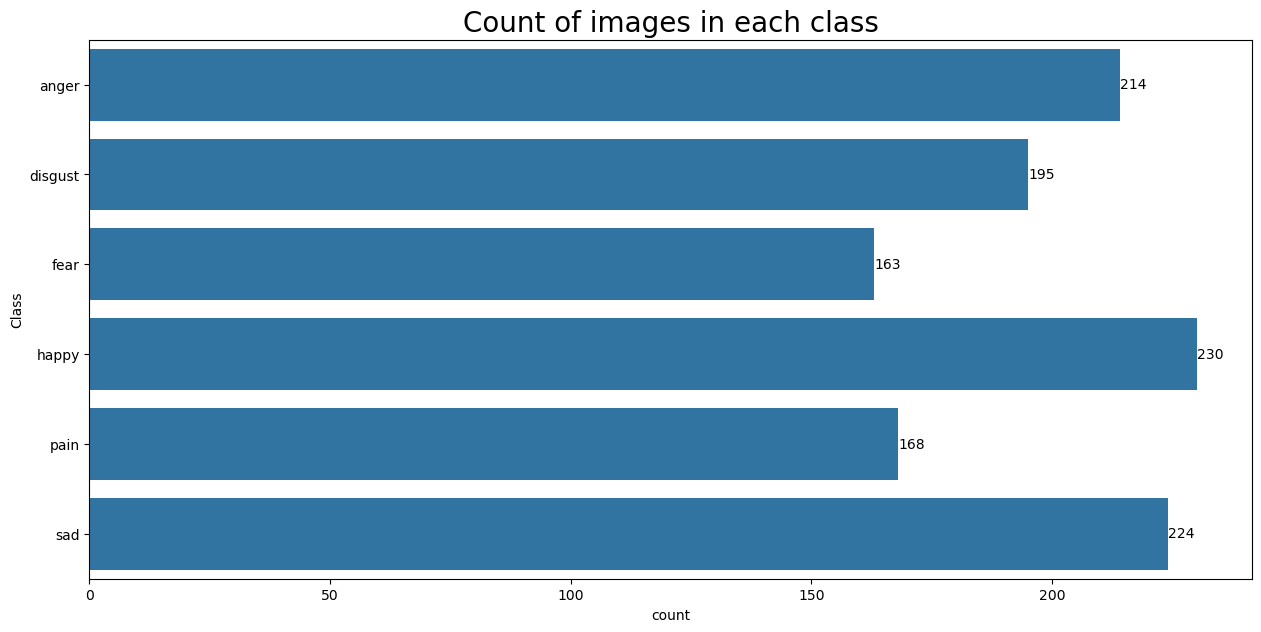

In [33]:
plt.figure(figsize=(15,7))
ax = sns.countplot(data=df , y=df['Class'])
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

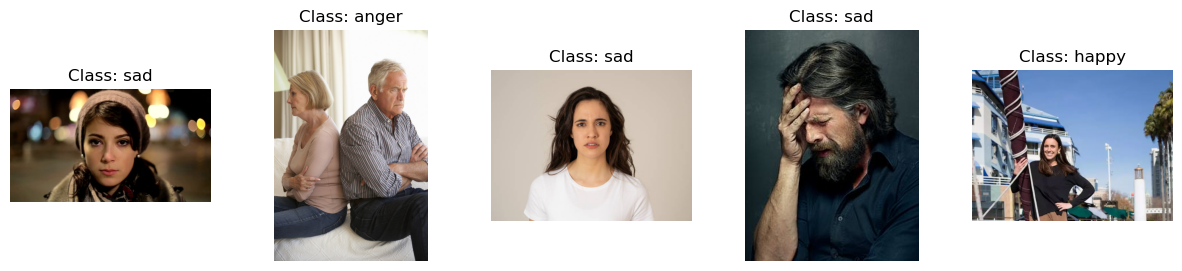

In [35]:
def display_random_images(df, num_images=5):
    random_indices = random.sample(range(len(df)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i, idx in enumerate(random_indices):
        image_path = df.loc[idx, 'Class Path']
        class_name = df.loc[idx, 'Class']

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(f'Class: {class_name}')
        axes[i].axis('off')
    plt.show()

display_random_images(df)

In [37]:
train_df, test_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 20)
valid_df, test_df = train_test_split(test_df,  train_size= 0.5, shuffle= True, random_state= 20)


In [39]:
valid_df.head()

,Class Path,Class
722,6 Emotions for image classification\happy.jpg\...,happy
1155,6 Emotions for image classification\sad.jpg\ee...,sad
75,6 Emotions for image classification\anger.jpg\...,anger
887,6 Emotions for image classification\pain.jpg\p...,pain
666,6 Emotions for image classification\happy.jpg\...,happy


In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set parameters
batch_size = 32
img_size = (299, 299)

# Define data augmentation for training
train_gen = ImageDataGenerator(
    rescale=1.0/255,  # Correct scaling value
    brightness_range=(0.8, 1.2),
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define rescaling for validation and testing
valid_test_datagen = ImageDataGenerator(rescale=1.0/255)  # Correct scaling value

# Create training generator
train_gen = train_gen.flow_from_dataframe(
    dataframe=train_df,  # Ensure 'train_df' is defined
    x_col='Class Path',
    y_col='Class',
    target_size=img_size,
    color_mode='rgb',  # Default is 'rgb', optional to keep
    class_mode='categorical',  # Specify class_mode for multi-class
    batch_size=batch_size,
    shuffle=True
)

# Create validation generator
valid_gen = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_df,  # Ensure 'valid_df' is defined
    x_col='Class Path',
    y_col='Class',
    target_size=img_size,
    color_mode='rgb',  # Default is 'rgb', optional to keep
    class_mode='categorical',  # Specify class_mode for multi-class
    batch_size=batch_size,
    shuffle=True
)

# Create test generator
test_gen = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,  # Ensure 'test_df' is defined
    x_col='Class Path',
    y_col='Class',
    target_size=img_size,
    color_mode='rgb',  # Default is 'rgb', optional to keep
    class_mode='categorical',  # Specify class_mode for multi-class
    batch_size=batch_size,
    shuffle=False  # Ensure shuffle is False for test data
)


Found 804 validated image filenames belonging to 6 classes.
Found 173 validated image filenames belonging to 6 classes.
Found 169 validated image filenames belonging to 6 classes.


In [45]:
# Define the input shape
img_shape = (299, 299, 3)

# Load the base model
base_model = tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=img_shape,
    pooling='max'
)

# Freeze the base model layers if you want to use transfer learning
for layer in base_model.layers:
    layer.trainable = False  # Uncomment if you want to freeze layers

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(512, activation='relu'),
    Dropout(rate=0.40),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(6, activation='softmax')  # Assuming you have 6 classes
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Display the model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,977,006 (83.84 MB)

 Trainable params: 1,115,526 (4.26 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [49]:
for layer in base_model.layers:
    layer.trainable = True

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,977,006 (83.84 MB)

 Trainable params: 21,922,478 (83.63 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [57]:
# Example of model training
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=25,  # Adjust the number of epochs as needed
    steps_per_epoch=len(train_gen),
    validation_steps=len(valid_gen)
)


Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 384s 13s/step - accuracy: 0.2501 - loss: 2.0633 - precision_2: 0.3337 - recall_2: 0.0429 - val_accuracy: 0.3237 - val_loss: 1.8415 - val_precision_2: 0.3810 - val_recall_2: 0.1387
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 346s 13s/step - accuracy: 0.3969 - loss: 1.5474 - precision_2: 0.8335 - recall_2: 0.0874 - val_accuracy: 0.4046 - val_loss: 1.8958 - val_precision_2: 0.4898 - val_recall_2: 0.2775
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 347s 13s/step - accuracy: 0.5400 - loss: 1.2647 - precision_2: 0.8239 - recall_2: 0.2722 - val_accuracy: 0.5434 - val_loss: 1.2724 - val_precision_2: 0.6607 - val_recall_2: 0.4277
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 

In [61]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_loss', 'val_precision_2', 'val_recall_2'])

In [73]:
# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(
    test_gen, 
    steps=len(test_gen)
)

# Print the evaluation results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6880 - loss: 1.6140 - precision_2: 0.6891 - recall_2: 0.6802
Test Loss: 1.6190
Test Accuracy: 0.6746
Test Precision: 0.6747
Test Recall: 0.6627


In [77]:
hist = history

dict_keys(['accuracy', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_loss', 'val_precision_2', 'val_recall_2'])


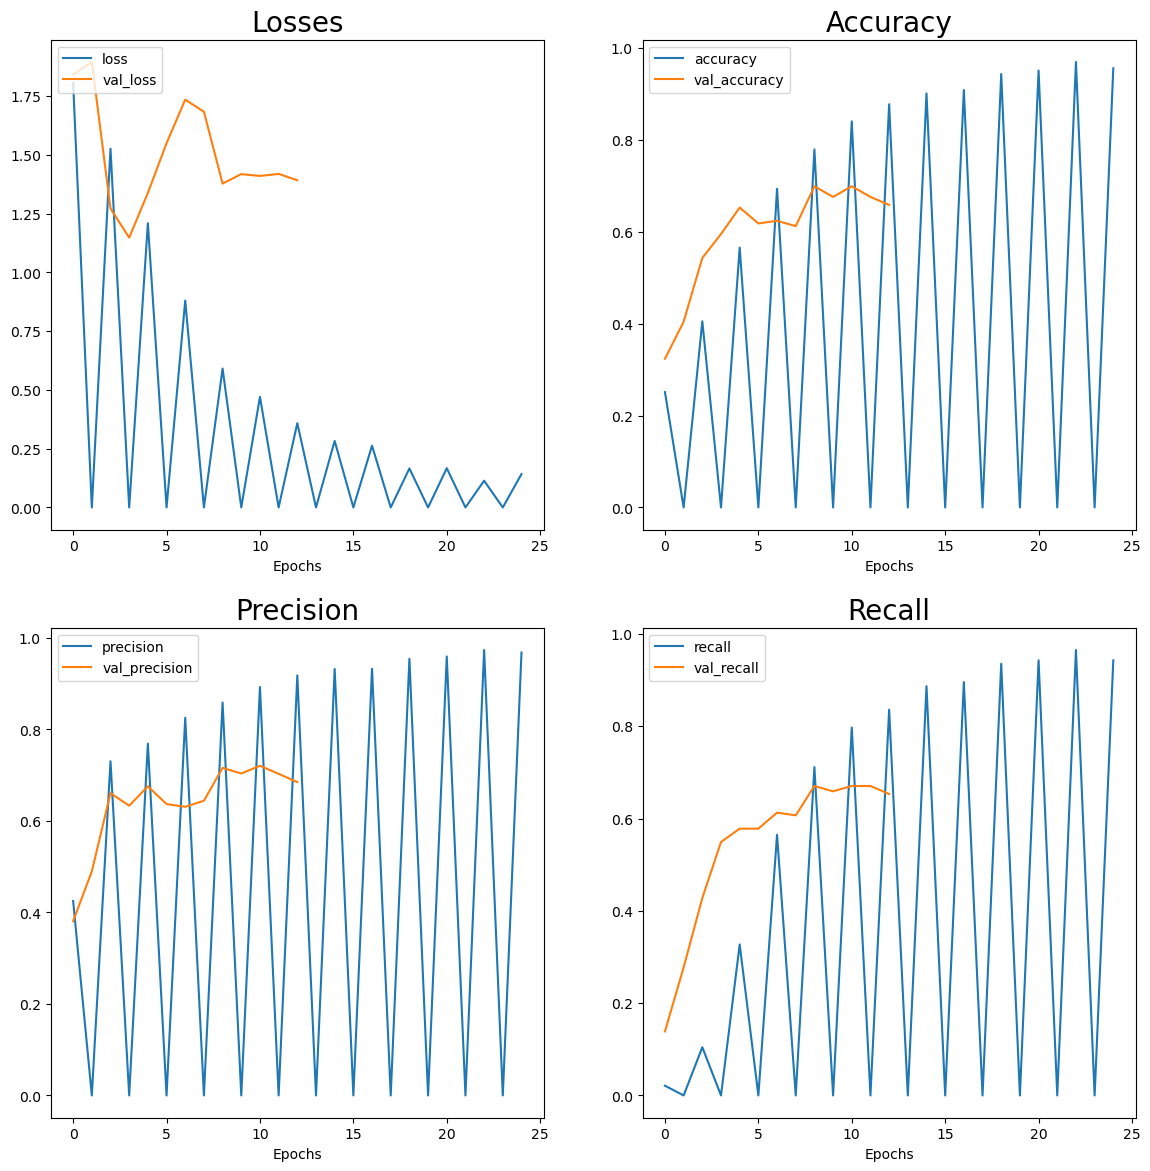

In [79]:

# Get available metric keys to verify naming
print(hist.history.keys())  # Check the exact names in hist.history

# Plot training metrics with corrected metric names
plt.figure(figsize=(14, 14))

# Plot loss
plt.subplot(2, 2, 1)
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.title('Losses', fontsize=20)
plt.xlabel('Epochs')
plt.legend(loc="upper left")

# Plot accuracy
plt.subplot(2, 2, 2)
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.xlabel('Epochs')
plt.legend(loc="upper left")

# Plot precision
precision_key = [key for key in hist.history.keys() if 'precision' in key][0]  # Dynamically find the precision key
val_precision_key = [key for key in hist.history.keys() if 'val_precision' in key][0]

plt.subplot(2, 2, 3)
plt.plot(hist.history[precision_key], label='precision')
plt.plot(hist.history[val_precision_key], label='val_precision')
plt.title('Precision', fontsize=20)
plt.xlabel('Epochs')
plt.legend(loc="upper left")

# Plot recall
recall_key = [key for key in hist.history.keys() if 'recall' in key][0]  # Dynamically find the recall key
val_recall_key = [key for key in hist.history.keys() if 'val_recall' in key][0]

plt.subplot(2, 2, 4)
plt.plot(hist.history[recall_key], label='recall')
plt.plot(hist.history[val_recall_key], label='val_recall')
plt.title('Recall', fontsize=20)
plt.xlabel('Epochs')
plt.legend(loc="upper left")

plt.show()


In [75]:
model.save('multimodal_sentiment_model_67.h5')